# Device

In [1]:
GPU_NUMBER = 4
DEVICE = 'cpu' if GPU_NUMBER < 0 else 'cuda:{}'.format(GPU_NUMBER)

In [2]:
DEVICE

'cuda:4'

# Requirements

In [3]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
import torch, torchvision
import mmseg
import mmcv

import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from PIL import Image

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor, set_random_seed, inference_segmentor

In [5]:
print(f"Torch version: {torch.__version__}. Cuda is avail? {torch.cuda.is_available()}")
print(f"MMSegmentation version: {mmseg.__version__}")

Torch version: 1.7.0. Cuda is avail? True
MMSegmentation version: 0.11.0


# Dataset

In [6]:
DATA_PATH = "/rd-temp/mohan/iccv09Data"
NUM_CLASSES = 8

img_dir = 'images'
ann_dir = 'labels'
data_root = DATA_PATH

In [7]:
# define class and plaette for better visualization
classes = (
    'sky', 'tree', 'road', 'grass', 
    'water', 'bldg', 'mntn', 'fg obj'
)
palette = [
    [128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
    [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]
]

In [8]:
## Prepare semantic segmentation ground truth data

regenerate_data = False

if regenerate_data:
    print("Regenerating data...")
    for file in mmcv.scandir(os.path.join(data_root, ann_dir), suffix='.regions.txt'):
        seg_map = np.loadtxt(os.path.join(data_root, ann_dir, file)).astype(np.uint8)
        seg_img = Image.fromarray(seg_map).convert('P')
        seg_img.putpalette(np.array(palette, dtype=np.uint8))
        seg_img.save(
            os.path.join(
                data_root, 
                ann_dir, 
                file.replace('.regions.txt', '.png')
            )
        )
    
    print("Preparing split data...")
    
    # split train/val set randomly
    split_dir = 'splits'
    mmcv.mkdir_or_exist(os.path.join(data_root, split_dir))
    filename_list = [
        os.path.splitext(filename)[0] for filename in mmcv.scandir(
            os.path.join(data_root, ann_dir), suffix='.png'
        )
    ]

    with open(os.path.join(data_root, split_dir, 'train.txt'), 'w') as f:
        # select first 4/5 as train set
        train_length = int(len(filename_list)*4/5)
        f.writelines(line + '\n' for line in filename_list[:train_length])

    with open(os.path.join(data_root, split_dir, 'val.txt'), 'w') as f:
        # select last 1/5 as train set
        f.writelines(line + '\n' for line in filename_list[train_length:])
        
    print("Done")

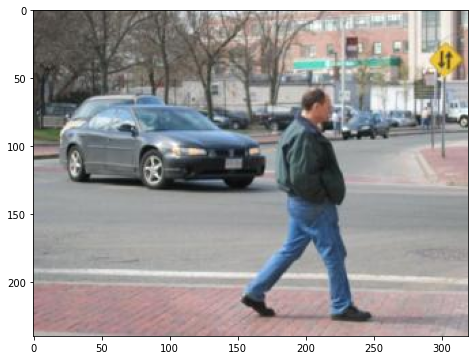

In [9]:
img = mmcv.imread(f'{DATA_PATH}/images/6000124.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

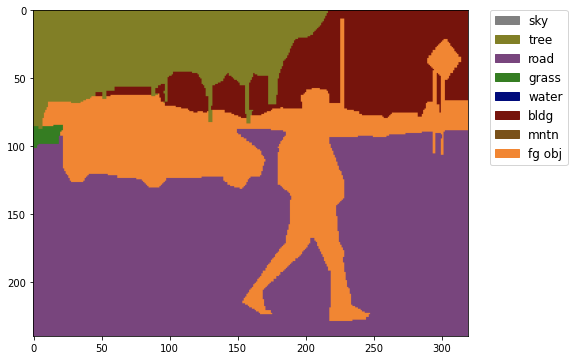

In [10]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open(f'{DATA_PATH}/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

## Training Process

- Data
- Config
- Training

### Register Dataset

In [11]:
@DATASETS.register_module()
class StandfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert os.path.exists(self.img_dir) and self.split is not None

### Prepare Config file

In [12]:
cfg = mmcv.Config.fromfile('../experiments/config_pspnet.py')

In [13]:
cfg

Config (path: ../experiments/config_pspnet.py): {'norm_cfg': {'type': 'SyncBN', 'requires_grad': True}, 'model': {'type': 'EncoderDecoder', 'backbone': {'type': 'ResNetV1c', 'depth': 50, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'dilations': (1, 1, 2, 4), 'strides': (1, 2, 1, 1), 'norm_cfg': {'type': 'SyncBN', 'requires_grad': True}, 'norm_eval': False, 'style': 'pytorch', 'contract_dilation': True}, 'decode_head': {'type': 'PSPHead', 'in_channels': 2048, 'in_index': 3, 'channels': 512, 'pool_scales': (1, 2, 3, 6), 'dropout_ratio': 0.1, 'num_classes': 19, 'norm_cfg': {'type': 'SyncBN', 'requires_grad': True}, 'align_corners': False, 'loss_decode': {'type': 'CrossEntropyLoss', 'use_sigmoid': False, 'loss_weight': 1.0}}, 'auxiliary_head': {'type': 'FCNHead', 'in_channels': 1024, 'in_index': 2, 'channels': 256, 'num_convs': 1, 'concat_input': False, 'dropout_ratio': 0.1, 'num_classes': 19, 'norm_cfg': {'type': 'SyncBN', 'requires_grad': True}, 'align_corners': False, 'loss_decode': {'

In [14]:
# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)

cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = NUM_CLASSES
cfg.model.auxiliary_head.num_classes = NUM_CLASSES

# Modify dataset type and path
cfg.dataset_type = 'StandfordBackgroundDataset'
cfg.data_root = DATA_PATH

cfg.data.samples_per_gpu = NUM_CLASSES
cfg.data.workers_per_gpu = NUM_CLASSES

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], 
    to_rgb=True
)

cfg.crop_size = (256, 256)

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '../work_dirs/tutorial'

cfg.runner = dict(type='IterBasedRunner', max_iters=100)
cfg.total_iters = 100
cfg.log_config.interval = 25
cfg.evaluation.interval = 50
cfg.checkpoint_config.interval = 25

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(GPU_NUMBER, GPU_NUMBER + 1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=8,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num

### Build Dataset

In [15]:
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

/data-non-pii-share/rd_ai/mohan/anaconda3/envs/open-mmlab-2/lib/python3.7/site-packages/mmcv/utils/misc.py:304: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-02-15 09:37:10,145 - mmseg - INFO - Loaded 572 images


In [16]:
# check dataset config
# `img_infos` fields includes all images and gt paths, we will show examples of them later
[(k, v) for k, v in datasets[0].__dict__.items() if k != "img_infos"]

[('pipeline',
  Compose(
      LoadImageFromFile(to_float32=False,color_type='color',imdecode_backend='cv2')
      LoadAnnotations(reduce_zero_label=False,imdecode_backend='pillow')
      Resize(img_scale=[(320, 240)], multiscale_mode=range, ratio_range=(0.5, 2.0), keep_ratio=True)
      RandomCrop(crop_size=(256, 256))
      RandomFlip(prob=0.5)
      PhotoMetricDistortion(brightness_delta=32, contrast_range=(0.5, 1.5), saturation_range=(0.5, 1.5), hue_delta=18)
      Normalize(mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375], to_rgb=True)
      Pad(size=(256, 256), size_divisor=None, pad_val=0)
      DefaultFormatBundle
      Collect(keys=['img', 'gt_semantic_seg'], meta_keys=('filename', 'ori_filename', 'ori_shape', 'img_shape', 'pad_shape', 'scale_factor', 'flip', 'flip_direction', 'img_norm_cfg'))
  )),
 ('img_dir', '/rd-temp/mohan/iccv09Data/images'),
 ('img_suffix', '.jpg'),
 ('ann_dir', '/rd-temp/mohan/iccv09Data/labels'),
 ('seg_map_suffix', '.png'),
 ('split', '/rd-

In [17]:
# show example paths in `img_info` dict
datasets[0].__dict__["img_infos"][:5]

[{'filename': '0000047.jpg', 'ann': {'seg_map': '0000047.png'}},
 {'filename': '0000051.jpg', 'ann': {'seg_map': '0000051.png'}},
 {'filename': '0000059.jpg', 'ann': {'seg_map': '0000059.png'}},
 {'filename': '0000072.jpg', 'ann': {'seg_map': '0000072.png'}},
 {'filename': '0000087.jpg', 'ann': {'seg_map': '0000087.png'}}]

### Build Detector

In [18]:
# Build the detector
model = build_segmentor(
    cfg.model
)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [19]:
model

EncoderDecoder(
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [20]:
model.CLASSES

('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')

### Training Process

In [21]:
# Create work_dir
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))

In [22]:
train_segmentor(
    model, 
    datasets, 
    cfg, 
    distributed=False, 
    validate=True, 
    meta=dict()
)

2021-02-15 09:37:13,380 - mmseg - INFO - Loaded 143 images
2021-02-15 09:37:13,381 - mmseg - INFO - load checkpoint from ../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2021-02-15 09:37:13,543 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
2021-02-15 09:37:13,563 - mmseg -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 14.1 task/s, elapsed: 10s, ETA:     0s

2021-02-15 09:37:44,061 - mmseg - INFO - per class results:
2021-02-15 09:37:44,063 - mmseg - INFO - 
+--------+-------+-------+
| Class  | IoU   | Acc   |
+--------+-------+-------+
| sky    | 86.69 | 92.71 |
| tree   | 70.49 | 84.43 |
| road   | 77.7  | 95.93 |
| grass  | 70.96 | 94.25 |
| water  | 0.0   | 0.0   |
| bldg   | 76.07 | 86.03 |
| mntn   | 0.0   | 0.0   |
| fg obj | 65.44 | 75.44 |
+--------+-------+-------+
2021-02-15 09:37:44,063 - mmseg - INFO - Summary:
2021-02-15 09:37:44,063 - mmseg - INFO - 
+--------+-------+------+-------+
| Scope  | mIoU  | mAcc | aAcc  |
+--------+-------+------+-------+
| global | 55.92 | 66.1 | 83.55 |
+--------+-------+------+-------+
2021-02-15 09:37:44,064 - mmseg - INFO - Iter(val) [50]	mIoU: 0.5592, mAcc: 0.6610, aAcc: 0.8355
2021-02-15 09:37:51,869 - mmseg - INFO - Saving checkpoint at 75 iterations
2021-02-15 09:37:54,077 - mmseg - INFO - Iter [75/100]	lr: 3.045e-03, eta: 0:00:10, time: 0.831, data_time: 0.464, memory: 3121, decode.los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 25.5 task/s, elapsed: 6s, ETA:     0s

2021-02-15 09:38:09,437 - mmseg - INFO - per class results:
2021-02-15 09:38:09,438 - mmseg - INFO - 
+--------+-------+-------+
| Class  | IoU   | Acc   |
+--------+-------+-------+
| sky    | 88.57 | 93.2  |
| tree   | 69.56 | 84.55 |
| road   | 79.66 | 95.93 |
| grass  | 79.15 | 88.74 |
| water  | 0.0   | 0.0   |
| bldg   | 73.4  | 91.48 |
| mntn   | 0.0   | 0.0   |
| fg obj | 65.21 | 73.38 |
+--------+-------+-------+
2021-02-15 09:38:09,439 - mmseg - INFO - Summary:
2021-02-15 09:38:09,439 - mmseg - INFO - 
+--------+-------+-------+-------+
| Scope  | mIoU  | mAcc  | aAcc  |
+--------+-------+-------+-------+
| global | 56.94 | 65.91 | 83.97 |
+--------+-------+-------+-------+
2021-02-15 09:38:09,440 - mmseg - INFO - Iter(val) [100]	mIoU: 0.5694, mAcc: 0.6591, aAcc: 0.8397


### Inference Test

In [23]:
image_path_random = np.random.choice(glob.glob(f'{DATA_PATH}/images/*.jpg'))
gt_image_path = image_path_random.replace("images", "labels").replace(".jpg", ".png")

print(f"Raw image: {image_path_random}")
print(f"GT label: {gt_image_path}")

Raw image: /rd-temp/mohan/iccv09Data/images/9003250.jpg
GT label: /rd-temp/mohan/iccv09Data/labels/9003250.png


In [24]:
img = mmcv.imread(image_path_random)

In [25]:
# Assign config to model (Required)
model.cfg = cfg

In [26]:
# Run inference
result = inference_segmentor(model, img)

In [27]:
model.cfg

Config (path: ../experiments/config_pspnet.py): {'norm_cfg': {'type': 'BN', 'requires_grad': True}, 'model': {'type': 'EncoderDecoder', 'backbone': {'type': 'ResNetV1c', 'depth': 50, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'dilations': (1, 1, 2, 4), 'strides': (1, 2, 1, 1), 'norm_cfg': {'type': 'BN', 'requires_grad': True}, 'norm_eval': False, 'style': 'pytorch', 'contract_dilation': True}, 'decode_head': {'type': 'PSPHead', 'in_channels': 2048, 'in_index': 3, 'channels': 512, 'pool_scales': (1, 2, 3, 6), 'dropout_ratio': 0.1, 'num_classes': 8, 'norm_cfg': {'type': 'BN', 'requires_grad': True}, 'align_corners': False, 'loss_decode': {'type': 'CrossEntropyLoss', 'use_sigmoid': False, 'loss_weight': 1.0}}, 'auxiliary_head': {'type': 'FCNHead', 'in_channels': 1024, 'in_index': 2, 'channels': 256, 'num_convs': 1, 'concat_input': False, 'dropout_ratio': 0.1, 'num_classes': 8, 'norm_cfg': {'type': 'BN', 'requires_grad': True}, 'align_corners': False, 'loss_decode': {'type': 'CrossEntro

In [28]:
result

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]])]

In [29]:
seg = result[0]

color_seg = np.zeros(img.shape, dtype=np.uint8)

print("Color Segmentation Mask Shape: ", color_seg.shape)

for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
    
# convert to BGR (it is required to convert segmentation mask to BGR to match raw image channel order)
color_seg = color_seg[..., ::-1]

Color Segmentation Mask Shape:  (262, 320, 3)


In [30]:
# Overlay segmentation mask on to original image
img_overlay = img * 0.5 + color_seg * 0.5
img_overlay = img_overlay.astype(np.uint8)

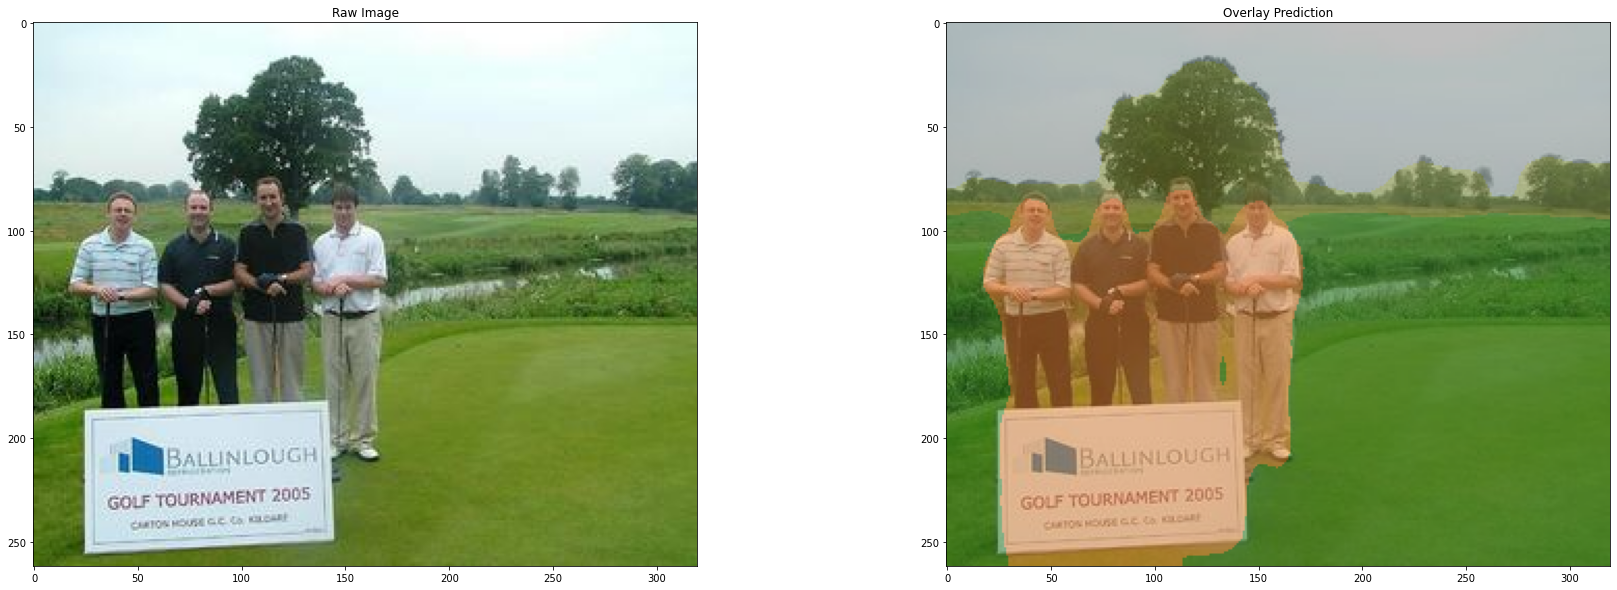

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

ax1.imshow(mmcv.bgr2rgb(img))
ax2.imshow(mmcv.bgr2rgb(img_overlay))

ax1.set_title("Raw Image")
ax2.set_title("Overlay Prediction")

plt.show()

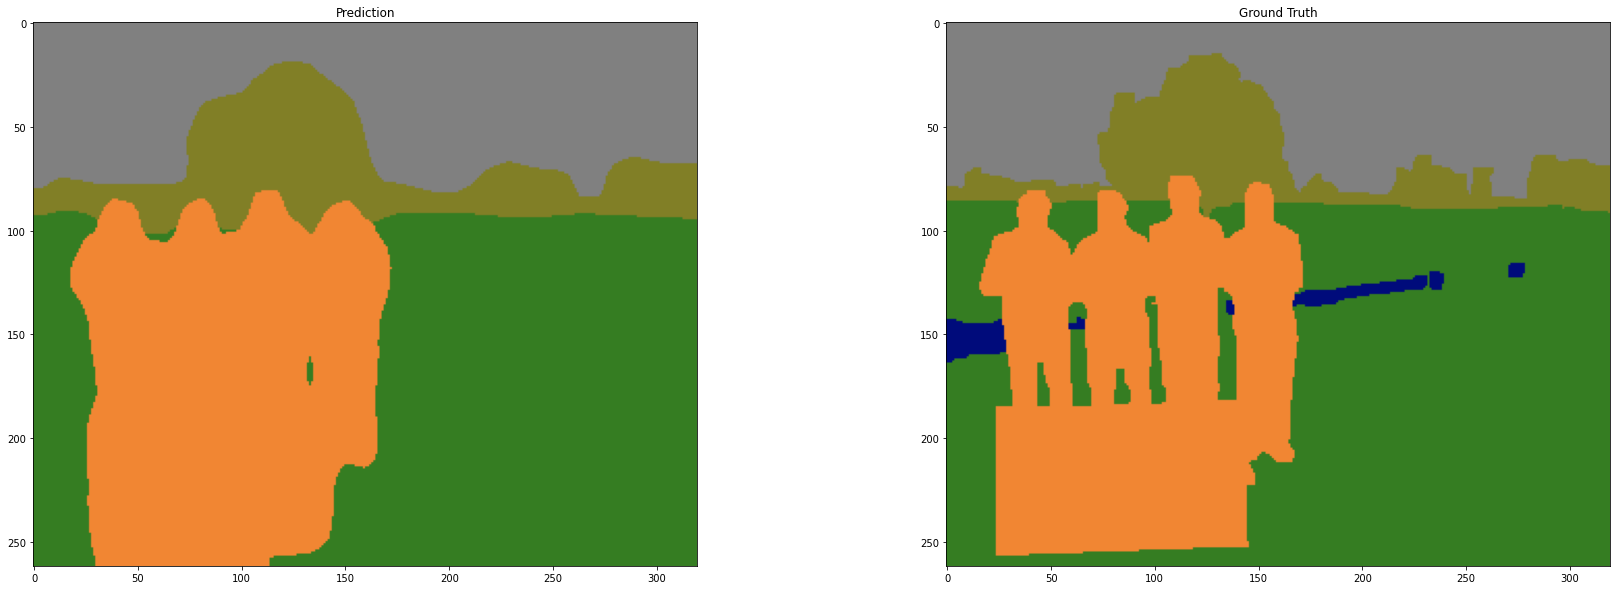

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

ax1.imshow(mmcv.bgr2rgb(color_seg))
ax2.imshow(mmcv.bgr2rgb(mmcv.imread(gt_image_path)))

ax1.set_title("Prediction")
ax2.set_title("Ground Truth")

plt.show()

## Training with combined config

In [40]:
cfg = mmcv.Config.fromfile('../experiments/config_standfordbackground.py')

In [41]:
## Setup experiment specific configs

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '../work_dirs/tutorial_2'

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)

# Set device
cfg.gpu_ids = range(GPU_NUMBER, GPU_NUMBER + 1)

In [42]:
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'StandfordBackgroundDataset'
data_root = '/rd-temp/mohan/iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
split_dir = 'splits'
num_classes = 8
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
image_scale_size = (320, 240)
crop_size = (256, 256)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(256, 256), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
       

In [43]:
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model
)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.PALETTE = datasets[0].PALETTE

# Create work_dir
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))

train_segmentor(
    model, 
    datasets, 
    cfg, 
    distributed=False, 
    validate=True, 
    meta=dict()
)

2021-02-15 11:59:23,559 - mmseg - INFO - Loaded 572 images
2021-02-15 11:59:24,313 - mmseg - INFO - Loaded 143 images
2021-02-15 11:59:24,314 - mmseg - INFO - load checkpoint from ../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2021-02-15 11:59:24,448 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 25.5 task/s, elapsed: 6s, ETA:     0s

2021-02-15 11:59:49,803 - mmseg - INFO - per class results:
2021-02-15 11:59:49,804 - mmseg - INFO - 
+--------+-------+-------+
| Class  | IoU   | Acc   |
+--------+-------+-------+
| sky    | 86.72 | 92.71 |
| tree   | 69.93 | 84.59 |
| road   | 79.02 | 95.37 |
| grass  | 66.25 | 95.11 |
| water  | 0.0   | 0.0   |
| bldg   | 76.14 | 84.74 |
| mntn   | 0.0   | 0.0   |
| fg obj | 66.75 | 77.46 |
+--------+-------+-------+
2021-02-15 11:59:49,804 - mmseg - INFO - Summary:
2021-02-15 11:59:49,805 - mmseg - INFO - 
+--------+------+-------+-------+
| Scope  | mIoU | mAcc  | aAcc  |
+--------+------+-------+-------+
| global | 55.6 | 66.25 | 83.58 |
+--------+------+-------+-------+
2021-02-15 11:59:49,805 - mmseg - INFO - Iter(val) [50]	mIoU: 0.5560, mAcc: 0.6625, aAcc: 0.8358
2021-02-15 11:59:57,683 - mmseg - INFO - Saving checkpoint at 75 iterations
2021-02-15 11:59:59,727 - mmseg - INFO - Iter [75/100]	lr: 3.045e-03, eta: 0:00:08, time: 0.647, data_time: 0.286, memory: 3499, decode.los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 25.5 task/s, elapsed: 6s, ETA:     0s

2021-02-15 12:00:15,014 - mmseg - INFO - per class results:
2021-02-15 12:00:15,015 - mmseg - INFO - 
+--------+-------+-------+
| Class  | IoU   | Acc   |
+--------+-------+-------+
| sky    | 88.65 | 92.94 |
| tree   | 70.23 | 87.25 |
| road   | 79.6  | 95.9  |
| grass  | 78.77 | 89.81 |
| water  | 0.0   | 0.0   |
| bldg   | 75.78 | 90.72 |
| mntn   | 0.0   | 0.0   |
| fg obj | 67.79 | 75.77 |
+--------+-------+-------+
2021-02-15 12:00:15,015 - mmseg - INFO - Summary:
2021-02-15 12:00:15,015 - mmseg - INFO - 
+--------+------+-------+------+
| Scope  | mIoU | mAcc  | aAcc |
+--------+------+-------+------+
| global | 57.6 | 66.55 | 84.6 |
+--------+------+-------+------+
2021-02-15 12:00:15,017 - mmseg - INFO - Iter(val) [100]	mIoU: 0.5760, mAcc: 0.6655, aAcc: 0.8460
